In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls
import os
import yaml
from yaml import Loader
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
from utils_graphs import create_graph, plot_graph, get_colors, fig_graph_degrees
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [3]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database()

In [4]:
path_c57_with_father = 'dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy'

path_c57_without_father = 'dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy'

path_wild_with_father = 'dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy'

path_wild_without_father = 'dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy'


In [4]:
# def plot_contrasts(df_data, index, ax):
#     df = df_data.iloc[index]
#     df = pd.DataFrame(df).T
#     df = pd.melt(df)
#     sns.barplot(x = df.value, 
#         y = df.variable, 
#         ax=ax,
#         data=df,
#         palette=sns.color_palette("Accent"))

In [5]:
def plot_saliences(df_data, index, ax, df_levels):
    df = df_data.iloc[index]
    df = pd.DataFrame(df).T
    df = pd.melt(df)
    df['Brain Hierarchy'] = [df_levels[df_levels['area']==area]['name_parent_l5'].values[0] for area in df['variable']]
    sns.barplot(y = df.value, 
                x = df.variable, 
                ax=ax, 
                hue=df['Brain Hierarchy'],
                data=df,
                dodge=False,
                palette=sns.color_palette("Paired"))

In [64]:
def figure_saliences(batch, volumes):
    saliences = pd.read_csv('./results_pls/'+batch+'_relative_density_saliences.csv')
    df_levels = upls.create_df_levels(volumes, level=8)
    
    fig, axes = plt.subplots(2,1, sharex='row', figsize=(12,3))
    plt.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.25)
    plot_saliences(df_data=saliences, index=0, ax=axes[0], df_levels=df_levels)
    plot_saliences(df_data=saliences, index=1, ax=axes[1], df_levels=df_levels)
    axes[0].tick_params(axis='x', labelrotation=90)
    axes[1].tick_params(axis='x', labelrotation=90, labelsize=12)
    axes[0].tick_params(axis='y', labelsize=10)
    axes[1].tick_params(axis='y', labelsize=10)
    axes[0].set_xlabel('')
    axes[0].set(xticklabels=[])
    axes[1].set_xlabel('')
    # axes[1].set(xticklabels=[])
    axes[0].set_ylabel('First salience', fontsize=10)
    axes[1].set_ylabel('Second salience', fontsize=10)
    fig.align_ylabels(axes)
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    for i in range(2):
        axes[i].axhline(y=2.56, linestyle='-.', color='darkgrey')
        axes[i].axhline(y=-2.56, linestyle='-.', color='darkgrey')
        [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
    plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/'+
                batch+'_pls_saliences_FENS.png', dpi=300)
    plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/'+
                batch+'_pls_saliences_FENS.svg')

# c57 WITH FATHER

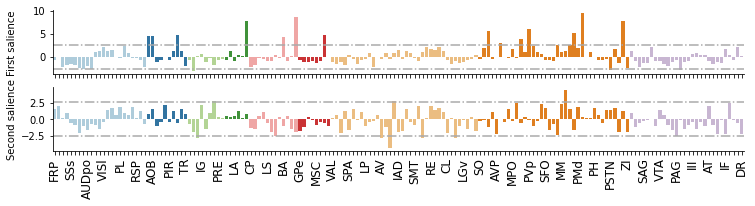

In [65]:
figure_saliences(batch='c57', 
                 volumes=volumes)

# c57 WITHOUT FATHER

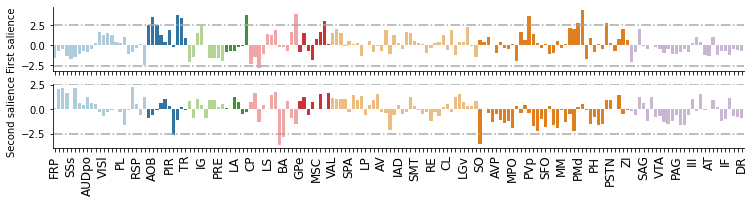

In [66]:
figure_saliences(batch='BL_woF2000', 
                 volumes=volumes)

# WILD with father

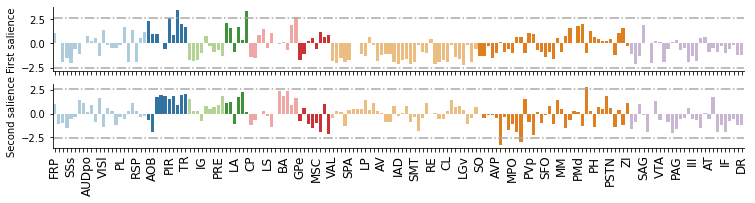

In [67]:
figure_saliences(batch='WILD_with_father2500', 
                 volumes=volumes)

# WILD without father

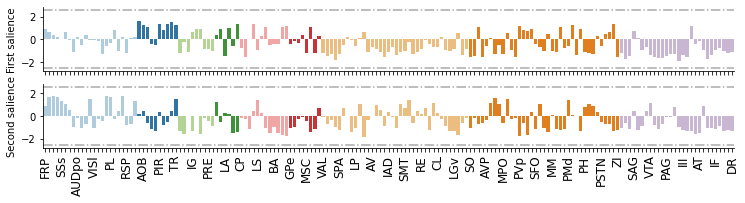

In [68]:
figure_saliences(batch='WILD_without_father2500', 
                 volumes=volumes)

# Number of cells & density per relevant area

In [8]:
def create_dfs(dictionary, experimental_groups, list_areas, value='n_cells'):
    df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    list_acronyms = [volumes.loc[volumes['safe_name'] == ac]['acronym'].values[0] for ac in list_areas]
    value = 'cells' if value=='n_cells' else 'density'
    control = pd.DataFrame(columns=['area', value, 'group'])
    fam = pd.DataFrame(columns=['area', value, 'group'])
    unfam = pd.DataFrame(columns=['area', value, 'group'])
    control['area'] = list_acronyms
    control['group'] = ['Control' for area in list_areas]
    control[value] = [df_control_cell_count.set_index('area').loc[area].mean() for area in list_areas]

    fam['area'] = list_acronyms
    fam['group'] = ['Familiar' for area in list_areas]
    fam[value] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in list_areas]

    unfam['area'] = list_acronyms
    unfam['group'] = ['Unfamiliar' for area in list_areas]
    unfam[value] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in list_areas]
    df = control.append(fam).append(unfam)
    
    return df

## WITH FATHER

In [9]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
batch='c57'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy', allow_pickle=True).item()
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

In [10]:
list_acronyms = ['ILA', 'MOB', 'AOB', 'AON','COA', 'PAA', 'IG', 'BMA', 'PA', 'SH', 'IA', 'MEA',
                'MSC', 'TRS', 'BST', 'AM','ARH', 'PD', 'PVp', 'TM', 'MPN', 'PMd', 'PMv',
                'PST', 'PSTN', 'TU', 'NB']
list_areas = [volumes.loc[volumes['acronym'] == ac]['safe_name'].values[0] for ac in list_acronyms]

In [11]:
with_father = create_dfs(dictionary=dict_results_across_mice, 
                         experimental_groups=experimental_groups, 
                         list_areas=list_areas,
                         value='n_cells')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


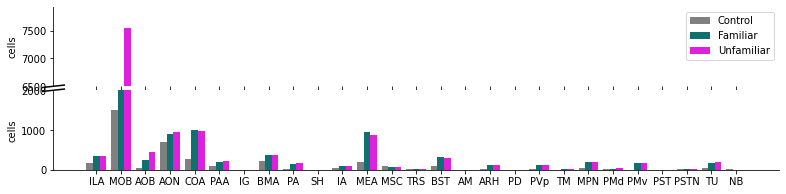

In [12]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.05}, figsize=(13,3))

# Define the custom color palette
custom_palette = ['#808080', '#007f7f', '#FF00FF']  # Grey, Petrol, Magenta

# Set the custom palette
sns.set_palette(custom_palette)

sns.barplot(
    data=with_father,
    x="area", y="cells", hue="group", palette=custom_palette, ax=ax_top)
sns.barplot(
    data=with_father,
    x="area", y="cells", hue="group", palette=custom_palette, ax=ax_bottom)
# sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_top)
# sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_bottom)
ax_top.set_ylim(bottom=6500)   # those limits are fake
ax_bottom.set_ylim(0,2000)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

#remove one of the legend
ax_bottom.legend_.remove()
ax_bottom.set_xlabel("")
ax_top.set_xlabel("")
ax_top.legend_.set_title("")
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_c57_WF.eps')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_c57_WF.png')

In [13]:
with_father_density = create_dfs(dictionary=dict_results_across_mice, 
                         experimental_groups=experimental_groups,
                                 list_areas=list_areas, value='density')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


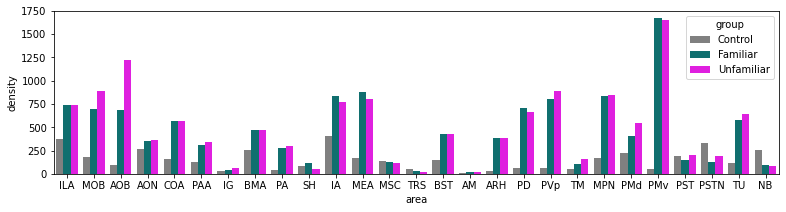

In [14]:
f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(13,3))

# Define the custom color palette
custom_palette = ['#808080', '#007f7f', '#FF00FF']  # Grey, Petrol, Magenta

# Set the custom palette
sns.set_palette(custom_palette)

sns.barplot(
    data=with_father_density,
    x="area", y="density", hue="group", palette=custom_palette, ax=ax)
# sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_top
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_c57_WF_density.eps')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_c57_WF_density.png')

## WITHOUT FATHER

In [15]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
batch='BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', 
                                   allow_pickle=True).item()
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [16]:
without_father = create_dfs(dictionary=dict_results_across_mice, 
                         experimental_groups=experimental_groups,
                                 list_areas=list_areas, value='n_cells')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


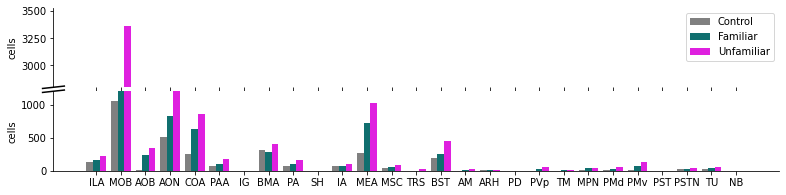

In [17]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.05}, figsize=(13,3))
# Define the custom color palette
custom_palette = ['#808080', '#007f7f', '#FF00FF']  # Grey, Petrol, Magenta

# Set the custom palette
sns.set_palette(custom_palette)


sns.barplot(
    data=without_father,
    x="area", y="cells", hue="group", palette=custom_palette, ax=ax_top)
sns.barplot(
    data=without_father,
    x="area", y="cells", hue="group", palette=custom_palette, ax=ax_bottom)
# sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_top)
# sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_bottom)
ax_top.set_ylim(bottom=2800)   # those limits are fake
ax_bottom.set_ylim(0,1200)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

#remove one of the legend
ax_bottom.legend_.remove()
ax_top.legend_.set_title("")
ax_top.set_xlabel("")
ax_bottom.set_xlabel("")
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hists_c57_WOF.eps')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hists_c57_WOF.png')

In [18]:
without_father_density = create_dfs(dictionary=dict_results_across_mice, 
                         experimental_groups=experimental_groups,
                                 list_areas=list_areas, value='density')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


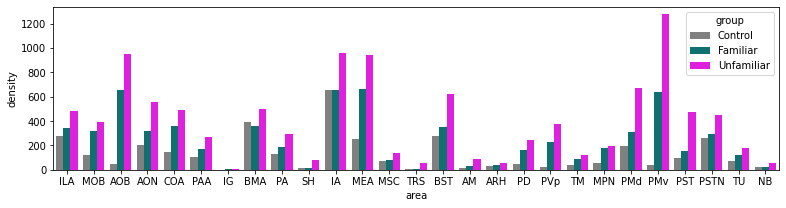

In [19]:
f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(13,3))

# Define the custom color palette
custom_palette = ['#808080', '#007f7f', '#FF00FF']  # Grey, Petrol, Magenta

# Set the custom palette
sns.set_palette(custom_palette)

sns.barplot(
    data=without_father_density,
    x="area", y="density", hue="group", palette=custom_palette, ax=ax)
# sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_top
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_c57_WOF_density.eps')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_c57_WOF_density.png')

## Together

In [20]:
def load_data(path, volumes, list_areas, value='n_cells'):
    dictionary = np.load(path, allow_pickle=True).item()
    dictionary = upls.reformat_dict_acronym(dict_results=dictionary, volumes=volumes)
    groups = utils.divide_in_exp_groups(list_subjects=list(dictionary.keys()))
    df = create_dfs(dictionary=dictionary,
                    experimental_groups=groups,
                    list_areas=list_areas, 
                    value=value)
    return df

In [21]:
# list_acronyms = ['ILA', 'MOB', 'AOB', 'AON','COA', 'PAA', 'BMA', 'PA', 'IA', 'MEA',
#                 'BST','ARH', 'PD', 'PVp', 'TM', 'MPN', 'PMd', 'PMv',
#                 'PST', 'PSTN', 'TU', 'NB']
# list_areas = [volumes.loc[volumes['acronym'] == ac]['safe_name'].values[0] for ac in list_acronyms]

# for j, value in enumerate(['n_cells', 'density']):

#     c57_with_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy',
#                                        volumes=volumes,
#                                        list_areas=list_areas,
#                                        value=value)

#     c57_without_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy',
#                                        volumes=volumes,
#                                        list_areas=list_areas,
#                                        value=value)

#     wild_with_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy',
#                                        volumes=volumes,
#                                        list_areas=list_areas,
#                                        value=value)

#     wild_without_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy',
#                                        volumes=volumes,
#                                        list_areas=list_areas,
#                                        value=value)

#     # Define the custom color palette
#     custom_palette = ['#808080', '#007f7f', '#FF00FF']  # Grey, Petrol, Magenta

#     # Set the custom palette
#     sns.set_palette(custom_palette)


#     for i, df in enumerate([c57_with_father,
#                c57_without_father,
#                wild_with_father,
#                wild_without_father]):
#         f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(13,3))
#         value_plot = 'cells' if value=='n_cells' else 'density'
#         sns.barplot(
#             data=df,
#             x="area", y=value_plot, hue="group", palette=custom_palette, ax=ax)
#         # sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_top
#         plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_'+
#                     str(j)+str(i)+'_'+value+'.svg')
#         plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_'+
#                     str(j)+str(i)+'_'+value+'.png')

### Now figures for WILD passing the KS test

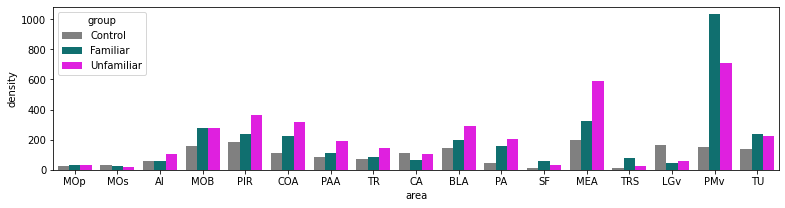

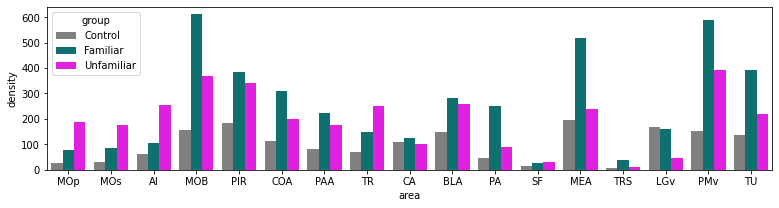

In [22]:

list_areas = [ 'Primary motor area',
              'Secondary motor area',
               'Agranular insular area',
               'Main olfactory bulb',
               'Piriform area',
                 'Cortical amygdalar area',
                 'Piriform-amygdalar area',
                 'Postpiriform transition area',
                 "Ammon's horn",
               'Basolateral amygdalar nucleus',
                 'Posterior amygdalar nucleus',
 'Septofimbrial nucleus',
 'Medial amygdalar nucleus',
 'Triangular nucleus of septum',
              
 'Ventral part of the lateral geniculate complex',
 'Ventral premammillary nucleus',
 'Tuberal nucleus']
list_acronyms = [volumes.loc[volumes['safe_name'] == ac]['acronym'].values[0] for ac in list_areas]

for j, value in enumerate(['density']):

    wild_with_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy',
                                       volumes=volumes,
                                       list_areas=list_areas,
                                       value=value)

    wild_without_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy',
                                       volumes=volumes,
                                       list_areas=list_areas,
                                       value=value)

    # Define the custom color palette
    custom_palette = ['#808080', '#007f7f', '#FF00FF']  # Grey, Petrol, Magenta

    # Set the custom palette
    sns.set_palette(custom_palette)


    for i, df in enumerate([
               wild_with_father,
               wild_without_father]):
        f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(13,3))
        value_plot = 'cells' if value=='n_cells' else 'density'
        sns.barplot(
            data=df,
            x="area", y=value_plot, hue="group", palette=custom_palette, ax=ax)
        # sns.violinplot(x="time", y="pulse", hue="kind",data=exercise, ax=ax_top
        plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_ks_wild_'+
                    str(j)+str(i)+'_'+value+'.svg')
        plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_ks_wild_'+
                    str(j)+str(i)+'_'+value+'.png')

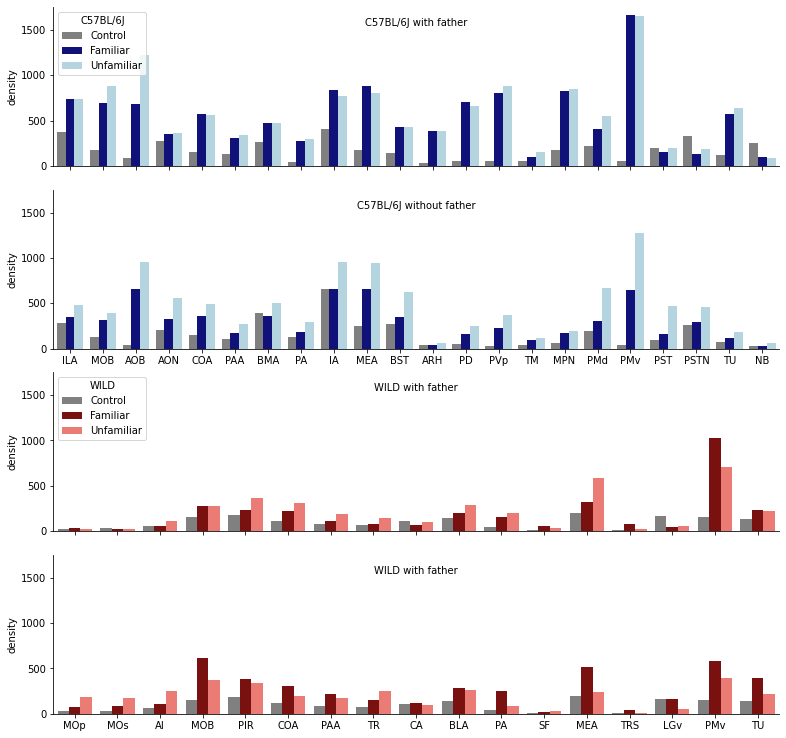

In [23]:
list_poster_acronyms_c57 = ['ILA', 'MOB', 'AOB', 'AON','COA', 'PAA', 'BMA', 'PA', 'IA', 'MEA',
                'BST','ARH', 'PD', 'PVp', 'TM', 'MPN', 'PMd', 'PMv',
                'PST', 'PSTN', 'TU', 'NB']
list_poster_areas_c57 = [volumes.loc[volumes['acronym'] == ac]['safe_name'].values[0] 
                         for ac in list_poster_acronyms_c57]

list_poster_areas_wild = ['Primary motor area',
              'Secondary motor area',
              'Agranular insular area',
              'Main olfactory bulb',
              'Piriform area',
              'Cortical amygdalar area',
              'Piriform-amygdalar area',
              'Postpiriform transition area',
              "Ammon's horn",
              'Basolateral amygdalar nucleus',
              'Posterior amygdalar nucleus',
              'Septofimbrial nucleus',
              'Medial amygdalar nucleus',
              'Triangular nucleus of septum',
              'Ventral part of the lateral geniculate complex',
              'Ventral premammillary nucleus',
              'Tuberal nucleus']
list_poster_acronyms_wild = [volumes.loc[volumes['safe_name'] == ac]['acronym'].values[0] 
                             for ac in list_poster_areas_wild]

titles = ['C57BL/6J with father', 'C57BL/6J without father',
         'WILD with father', 'WILD with father']

for j, value in enumerate(['density']):

    c57_with_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy',
                                       volumes=volumes,
                                       list_areas=list_poster_areas_c57,
                                       value=value)

    c57_without_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy',
                                       volumes=volumes,
                                       list_areas=list_poster_areas_c57,
                                       value=value)

    wild_with_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy',
                                       volumes=volumes,
                                       list_areas=list_poster_areas_wild,
                                       value=value)

    wild_without_father = load_data(path='dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy',
                                       volumes=volumes,
                                       list_areas=list_poster_areas_wild,
                                       value=value)


    f, ax = plt.subplots(ncols=1, nrows=4, gridspec_kw={'hspace':0.15}, figsize=(13,13), sharey=True)
    value_plot = 'cells' if value=='n_cells' else 'density'
    for i, df in enumerate([c57_with_father,
           c57_without_father,
           wild_with_father,
           wild_without_father]):
        if i<2:
            # Define the custom blue color palette
            custom_palette = ['#808080', '#00008B', '#ADD8E6'] 
        else:    
            # Define the custom red color palette
            custom_palette = ['#808080', '#8B0000', '#FF6961']  
        # Set the custom palette
        sns.set_palette(custom_palette)
            
        sns.barplot(
            data=df,
            x="area", y=value_plot, hue="group", palette=custom_palette, ax=ax[i])
        ax[i].set_xlabel('')
        if i not in set([1,3]):
            ax[i].set(xticklabels=[])
        ax[i].legend(loc='upper left')
        if i not in set([0,2]):
            ax[i].legend_.remove()
        # Add a title inside each panel
        ax[i].text(0.5, 0.9, titles[i], 
                   horizontalalignment='center', 
                   verticalalignment='center', 
                   transform=ax[i].transAxes)
        
        # Remove the top and right spines
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
    
    ax[0].legend_.set_title("C57BL/6J")
    ax[2].legend_.set_title("WILD")
    plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_all'
                +value+'.svg')
    plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/hists_all'
                +value+'.png')

# GRAPH DISTRIBUTIONS

In [24]:
def create_graph_stats(path, volumes, batch):
    dictionary = np.load(path, allow_pickle=True).item()
    subjects = list(dictionary.keys())
    experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
    corr_threshold = 0.75
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)
    df_control, df_fam, df_unfam = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value='n_cells')
    sig_areas = ace.select_significant_areas(dictionary=dictionary, 
                                                 experimental_groups=experimental_groups, 
                                                 batch=batch,
                                                 test='mannwhitneyu', 
                                                 threshold_test=0.05,
                                                 threshold_pls=2.56,
                                                 value_test='n_cells', 
                                                 value_pls='relative_density')
    corr_matrix_control = ace.cross_corr(df_control)
    corr_matrix_fam = ace.cross_corr(df_fam)
    corr_matrix_unfam = ace.cross_corr(df_unfam)
    G_control = create_graph(corr_matrix_control, volumes=volumes, 
                             significant_areas=sig_areas, 
                             corr_threshold=corr_threshold, correlations='one')
    G_fam = create_graph(corr_matrix_fam,  volumes=volumes, 
                             significant_areas=sig_areas, 
                             corr_threshold=corr_threshold, correlations='one')
    G_unfam = create_graph(corr_matrix_unfam,  volumes=volumes, 
                             significant_areas=sig_areas, 
                             corr_threshold=corr_threshold, correlations='one')
    return [G_control, G_fam, G_unfam]

In [25]:
c57_wf_graphs = create_graph_stats(path='dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy', 
                                   volumes=volumes, 
                                   batch='c57')

In [26]:
c57_wof_graphs = create_graph_stats(path='dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', 
                                   volumes=volumes, 
                                   batch='BL_woF2000')

In [27]:
wild_wf_graphs = create_graph_stats(path='dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy', 
                                   volumes=volumes, 
                                   batch='WILD_with_father2500')

In [28]:
wild_wof_graphs = create_graph_stats(path='dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', 
                                   volumes=volumes, 
                                   batch='WILD_without_father2500')

In [37]:
graphs = c57_wf_graphs + c57_wof_graphs
# graphs = wild_wf_graphs + wild_wof_graphs

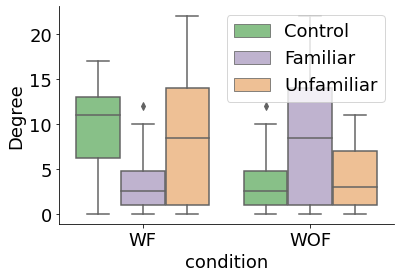

In [38]:

def degrees(graphs):
    degree = [dict(nx.degree(G)) for G in graphs]
    df_degree = pd.DataFrame(columns=['area', 'Degree',
                                      'group', 'condition'])
    for i, cond in enumerate(['WF', 'WOF']):
        for j, group in enumerate(['Control', 'Familiar', 'Unfamiliar']):
            df = pd.DataFrame(columns=['area', 'Degree',
                                       'group', 'condition'])
            #idea
            df['area'] = degree[i+j].keys()
            df['group'] = [group for i in range(len(list(degree[i+j].keys())))]
            df['condition'] = [cond for i in range(len(list(degree[i+j].keys())))]
            df['Degree'] = degree[i+j].values()
            df_degree = df_degree.append(df)
    return df_degree

df_degree = degrees(graphs=graphs)
        
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_degree, x='condition', 
               y='Degree', hue='group',
              palette='Accent', ax=ax)
sns.despine(right=True)
ax.legend_.set_title("")

## PLOT BETWEENNESS

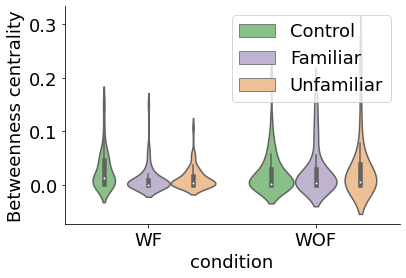

In [39]:
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame(columns=['area', 'Betweenness centrality', 
                                             'Group', 'Condition'])
for i, cond in enumerate(['WF', 'WOF']):
    for j, group in enumerate(['Control', 'Familiar', 'Unfamiliar']):
        df = pd.DataFrame(columns=['area', 'Betweenness centrality',
                                   'group', 'condition'])
        if i == 0 and j == 0:
            k = 0
        elif i == 0 and j == 1:
            k = 1
        elif i == 0 and j == 2:
            k = 2
        elif i == 1 and j == 0:
            k = 3
        elif i == 1 and j == 1:
            k = 4
        elif i == 1 and j == 2:
            k = 5        
        #idea
        df['area'] = betweenness_centrality[k].keys()
        df['group'] = [group for i in range(len(list(betweenness_centrality[k].keys())))]
        df['condition'] = [cond for i in range(len(list(betweenness_centrality[k].keys())))]
        df['Betweenness centrality'] = betweenness_centrality[k].values()
        df_betweenness_centrality = df_betweenness_centrality.append(df)
        
fig, ax = plt.subplots(1,1)
sns.violinplot(data=df_betweenness_centrality, x='condition', 
               y='Betweenness centrality', hue='group',
              palette='Accent', ax=ax)
sns.despine(right=True)
ax.legend_.set_title("")

## PLOT DEGREE CENTRALITY

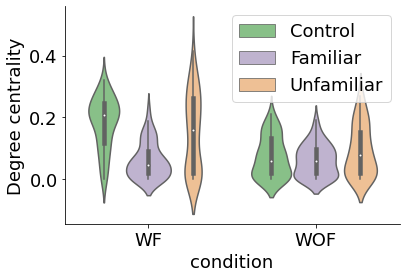

In [40]:
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame(columns=['area', 'Degree centrality', 
                                             'Group', 'Condition'])
for i, cond in enumerate(['WF', 'WOF']):
    for j, group in enumerate(['Control', 'Familiar', 'Unfamiliar']):
        df = pd.DataFrame(columns=['area', 'betweenness centrality',
                                   'group', 'condition'])
        if i == 0 and j == 0:
            k = 0
        elif i == 0 and j == 1:
            k = 1
        elif i == 0 and j == 2:
            k = 2
        elif i == 1 and j == 0:
            k = 3
        elif i == 1 and j == 1:
            k = 4
        elif i == 1 and j == 2:
            k = 5 
        #idea
        df['area'] = degree_centrality[k].keys()
        df['group'] = [group for i in range(len(list(degree_centrality[k].keys())))]
        df['condition'] = [cond for i in range(len(list(degree_centrality[k].keys())))]
        df['Degree centrality'] = degree_centrality[k].values()
        df_degree_centrality = df_degree_centrality.append(df)
        
fig, ax = plt.subplots(1,1)
sns.violinplot(data=df_degree_centrality, x='condition', 
               y='Degree centrality', hue='group',
              palette='Accent', ax=ax)
sns.despine(right=True)
ax.legend_.set_title("")

## CLUSTERING

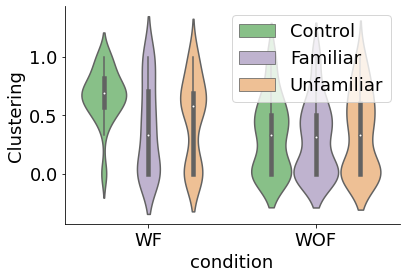

In [41]:
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame(columns=['area', 'Clustering', 
                                             'Group', 'Condition'])
for i, cond in enumerate(['WF', 'WOF']):
    for j, group in enumerate(['Control', 'Familiar', 'Unfamiliar']):
        df = pd.DataFrame(columns=['area', 'Clustering',
                                   'group', 'condition'])
        if i == 0 and j == 0:
            k = 0
        elif i == 0 and j == 1:
            k = 1
        elif i == 0 and j == 2:
            k = 2
        elif i == 1 and j == 0:
            k = 3
        elif i == 1 and j == 1:
            k = 4
        elif i == 1 and j == 2:
            k = 5 
        #idea
        df['area'] = clustering[k].keys()
        df['group'] = [group for i in range(len(list(clustering[k].keys())))]
        df['condition'] = [cond for i in range(len(list(clustering[k].keys())))]
        df['Clustering'] = clustering[k].values()
        df_clustering = df_clustering.append(df)
        
fig, ax = plt.subplots(1,1)
sns.violinplot(data=df_clustering, x='condition', 
               y='Clustering', hue='group',
              palette='Accent', ax=ax)
sns.despine(right=True)
ax.legend_.set_title("")

## RICH CLUB COEFFICIENT

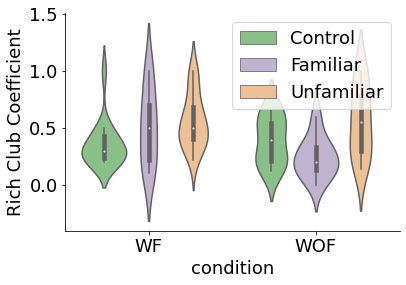

In [42]:
rich_club_coefficient = [nx.rich_club_coefficient(G, normalized=False) for G in graphs]
df_rich_club_coefficient = pd.DataFrame(columns=['area', 'Rich Club Coefficient', 
                                             'Group', 'Condition'])
for i, cond in enumerate(['WF', 'WOF']):
    for j, group in enumerate(['Control', 'Familiar', 'Unfamiliar']):
        df = pd.DataFrame(columns=['area', 'Rich Club Coefficient',
                                   'group', 'condition'])
        if i == 0 and j == 0:
            k = 0
        elif i == 0 and j == 1:
            k = 1
        elif i == 0 and j == 2:
            k = 2
        elif i == 1 and j == 0:
            k = 3
        elif i == 1 and j == 1:
            k = 4
        elif i == 1 and j == 2:
            k = 5 
        #idea
        df['area'] = rich_club_coefficient[k].keys()
        df['group'] = [group for i in range(len(list(rich_club_coefficient[k].keys())))]
        df['condition'] = [cond for i in range(len(list(rich_club_coefficient[k].keys())))]
        df['Rich Club Coefficient'] = rich_club_coefficient[k].values()
        df_rich_club_coefficient = df_rich_club_coefficient.append(df)
        
fig, ax = plt.subplots(1,1)
sns.violinplot(data=df_rich_club_coefficient, x='condition', 
               y='Rich Club Coefficient', hue='group',
              palette='Accent', ax=ax)
sns.despine(right=True)
ax.legend_.set_title("")

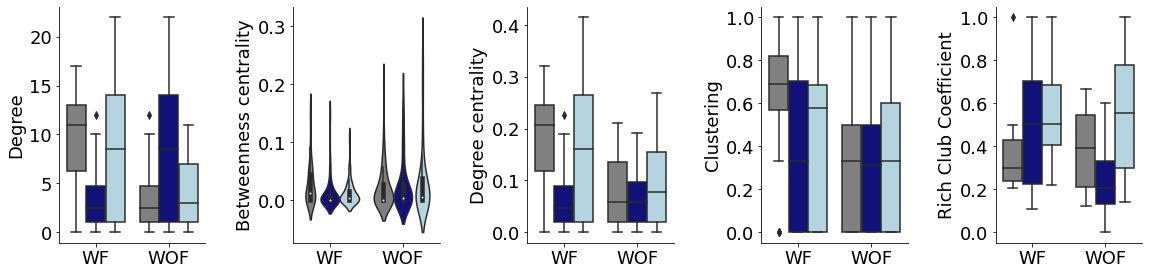

In [43]:
fig, axes = plt.subplots(1,5, figsize=(16,4))
plt.subplots_adjust(top=0.97, bottom=0.15, right=0.99, left=0.05, wspace=0.6)
fig.align_ylabels(axes)
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18

# Define the custom color palette
custom_palette = ['#808080', '#00008B', '#ADD8E6'] #blue
# custom_palette = ['#808080', '#8B0000', '#FF6961'] #red

# Set the custom palette
sns.set_palette(custom_palette)
        
sns.boxplot(data=df_degree, x='condition', 
               y='Degree', hue='group',
              palette=custom_palette, ax=axes[0])
sns.despine(right=True)
ax.legend_.set_title("")
axes[0].get_legend().remove()
axes[0].set_xlabel('')

sns.violinplot(data=df_betweenness_centrality, x='condition', 
               y='Betweenness centrality', hue='group',
              palette=custom_palette, inner='box',ax=axes[1])
sns.despine(right=True)
axes[1].get_legend().remove()
axes[1].set_xlabel('')

sns.boxplot(data=df_degree_centrality, x='condition', 
               y='Degree centrality', hue='group',
              palette=custom_palette, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set_xlabel('')

sns.boxplot(data=df_clustering, x='condition', 
               y='Clustering', hue='group',
              palette=custom_palette, ax=axes[3])
sns.despine(right=True)
axes[3].get_legend().remove()
axes[3].set_xlabel('')

sns.boxplot(data=df_rich_club_coefficient, x='condition', 
               y='Rich Club Coefficient', hue='group',
              palette=custom_palette, ax=axes[4])
sns.despine(right=True)
axes[4].get_legend().remove()
axes[4].set_xlabel('')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/graph_distributions5.eps')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/graph_distributions5.png')

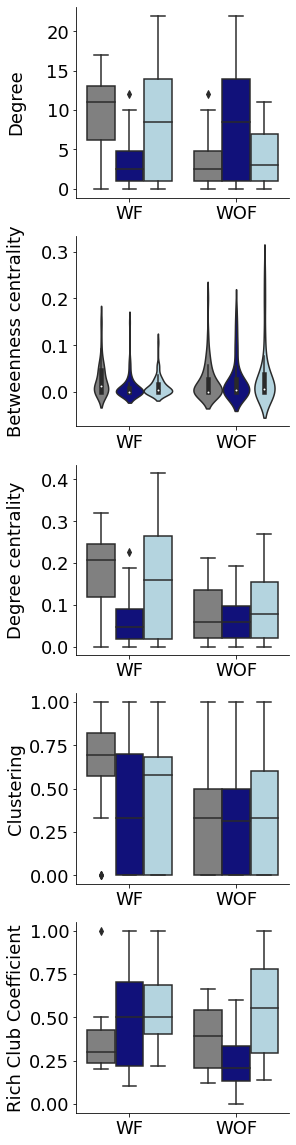

In [44]:
fig, axes = plt.subplots(5,1, figsize=(4,16))
plt.subplots_adjust(top=0.99, bottom=0.03, right=0.99, left=0.25, wspace=0.6)
fig.align_ylabels(axes)
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18

# Define the custom color palette
custom_palette = ['#808080', '#00008B', '#ADD8E6'] #blue
# custom_palette = ['#808080', '#8B0000', '#FF6961'] #red

# Set the custom palette
sns.set_palette(custom_palette)
        
sns.boxplot(data=df_degree, x='condition', 
               y='Degree', hue='group',
              palette=custom_palette, ax=axes[0])
sns.despine(right=True)
ax.legend_.set_title("")
axes[0].get_legend().remove()
axes[0].set_xlabel('')

sns.violinplot(data=df_betweenness_centrality, x='condition', 
               y='Betweenness centrality', hue='group',
              palette=custom_palette, inner='box',ax=axes[1])
sns.despine(right=True)
axes[1].get_legend().remove()
axes[1].set_xlabel('')

sns.boxplot(data=df_degree_centrality, x='condition', 
               y='Degree centrality', hue='group',
              palette=custom_palette, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set_xlabel('')

sns.boxplot(data=df_clustering, x='condition', 
               y='Clustering', hue='group',
              palette=custom_palette, ax=axes[3])
sns.despine(right=True)
axes[3].get_legend().remove()
axes[3].set_xlabel('')

sns.boxplot(data=df_rich_club_coefficient, x='condition', 
               y='Rich Club Coefficient', hue='group',
              palette=custom_palette, ax=axes[4])
sns.despine(right=True)
axes[4].get_legend().remove()
axes[4].set_xlabel('')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/graph_distributions5.eps')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/graph_distributions5.png', dpi=300)

# BOXPLOTS

# FOLD CHANGE

## WITH FATHER

In [39]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
batch='c57'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_c57.npy', allow_pickle=True).item()
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

KeyError: 'BL53Control'

In [ ]:
control = pd.DataFrame(columns=['area', 'cells', 'group'])
fam = pd.DataFrame(columns=['area', 'cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'cells', 'group'])
control['area'] = list_acronyms
control['group'] = ['Control' for area in list_areas]
control['cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in list_areas]

fam['area'] = list_acronyms
fam['group'] = ['Familiar' for area in list_areas]
fam['cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in list_areas]

unfam['area'] = list_acronyms
unfam['group'] = ['Unfamiliar' for area in list_areas]
unfam['cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in list_areas]
fold_change_wf = pd.DataFrame(columns=['area', 'fold change', 'group'])
fold_change_wf['area'] = [area for area in list_acronyms] + [area for area in list_acronyms]
fold_change_wf['group'] = ['Familiar' for area in list_areas] + ['Unfamiliar' for area in list_areas]
fold_change_wf['fold change'] = fam['cells'].div(control['cells']).append(unfam['cells'].div(control['cells'])).tolist()

In [ ]:
palette_accent = sns.color_palette("Accent", 3)
palette = sns.color_palette([palette_accent[1], palette_accent[2]])
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,3))
plt.subplots_adjust(bottom=0.2)
sns.barplot(
    data=fold_change_wf,
    x="area", y="fold change", hue="group", palette=palette, ax=ax)
ax.set_ylim(0,70)
sns.despine(ax=ax, right=True)
ax.legend_.set_title("")
ax.get_legend().remove()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/foldchange_c57_WF.eps')

## WITHOUT FATHER

In [ ]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
batch='BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_BL_woF2000.npy', allow_pickle=True).item()
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [ ]:
control = pd.DataFrame(columns=['area', 'cells', 'group'])
fam = pd.DataFrame(columns=['area', 'cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'cells', 'group'])
control['area'] = list_acronyms
control['group'] = ['Control' for area in list_areas]
control['cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in list_areas]

fam['area'] = list_acronyms
fam['group'] = ['Familiar' for area in list_areas]
fam['cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in list_areas]

unfam['area'] = list_acronyms
unfam['group'] = ['Unfamiliar' for area in list_areas]
unfam['cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in list_areas]
fold_change_wof = pd.DataFrame(columns=['area', 'fold change', 'group'])
fold_change_wof['area'] = [area for area in list_acronyms] + [area for area in list_acronyms]
fold_change_wof['group'] = ['Familiar' for area in list_areas] + ['Unfamiliar' for area in list_areas]
fold_change_wof['fold change'] = fam['cells'].div(control['cells']).append(unfam['cells'].div(control['cells'])).tolist()

In [ ]:
palette_accent = sns.color_palette("Accent", 3)
palette = sns.color_palette([palette_accent[1], palette_accent[2]])
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,3))
plt.subplots_adjust(bottom=0.2)
sns.barplot(
    data=fold_change_wof,
    x="area", y="fold change", hue="group", palette=palette, ax=ax)

sns.despine(ax=ax, right=True)
ax.set_ylim(0,70)
ax.legend_.set_title("")
ax.get_legend().remove()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/foldchange_c57_WOF.eps')